In [1]:
import numpy as np
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
import warnings
from itertools import product
from polarization_controller import polarization_bidi
from scipy.optimize import minimize
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")

In [2]:
p_bidi = polarization_bidi(tx_num_mzi_stages = 1, psr_bool=True, mzi_bool=True, rx_num_mzi_stages=1)

In [3]:
sample_points = 201

phase_shifts = np.linspace(-np.pi, np.pi, sample_points)

rotation_rx = phase_shifts[np.random.permutation(sample_points)]
rotation_ry = phase_shifts[np.random.permutation(sample_points)]
rotation_rz = phase_shifts[np.random.permutation(sample_points)]
rotation_delta = phase_shifts[np.random.permutation(sample_points)]

p_bidi.fiber_1._rotation = (rotation_rx[0], rotation_ry[0], rotation_rz[0], rotation_delta[0])
p_bidi.fiber_2._rotation = (rotation_rx[1], rotation_ry[1], rotation_rz[1], rotation_delta[1])
p_bidi.fiber_3._rotation = (rotation_rx[2], rotation_ry[2], rotation_rz[2], rotation_delta[2])
p_bidi.fiber_4._rotation = (rotation_rx[3], rotation_ry[3], rotation_rz[3], rotation_delta[3])
p_bidi.fiber_5._rotation = (rotation_rx[4], rotation_ry[4], rotation_rz[4], rotation_delta[4])
p_bidi.fiber_6._rotation = (rotation_rx[5], rotation_ry[5], rotation_rz[5], rotation_delta[5])
p_bidi.fiber_7._rotation = (rotation_rx[6], rotation_ry[6], rotation_rz[6], rotation_delta[6])

p_bidi.oc_1._return_loss = -35
p_bidi.oc_2._return_loss = -35
p_bidi.oc_3._return_loss = -35
p_bidi.oc_4._return_loss = -35
p_bidi.oc_5._return_loss = -35
p_bidi.oc_6._return_loss = -35

p_bidi.recursive_update()

In [4]:
no_sweep = 21
voltages = np.linspace(-2.7, 2.7, no_sweep)

transmit_tm_forward = []
transmit_te_forward  = []
reflect_te_forward = []
reflect_tm_forward = []

transmit_tm_reverse = []
transmit_te_reverse  = []
reflect_te_reverse = []
reflect_tm_reverse = []

input_state_forward = np.array([1, 0, 0, 0])
input_state_reverse = np.array([0, 0, 1, 0])

for tx_pa_voltage, tx_mzi_voltage, rx_pa_voltage, rx_mzi_voltage in tqdm(product(voltages, voltages, voltages, voltages), total=no_sweep**4):
  p_bidi.bidi_tx.pa.XPS1.heater_voltage = 0.0
  p_bidi.bidi_tx.pa.XPS2.heater_voltage = 0.0
  if tx_pa_voltage > 0.0:
    p_bidi.bidi_tx.pa.XPS1.heater_voltage = tx_pa_voltage
  if tx_pa_voltage < 0.0:
    p_bidi.bidi_tx.pa.XPS2.heater_voltage = -tx_pa_voltage

  p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = 0.0
  p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = 0.0
  if tx_mzi_voltage > 0.0:
    p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = tx_mzi_voltage
  if tx_mzi_voltage < 0.0:
    p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = -tx_mzi_voltage

  p_bidi.bidi_rx.pa.XPS1.heater_voltage = 0.0
  p_bidi.bidi_rx.pa.XPS2.heater_voltage = 0.0
  if rx_pa_voltage > 0.0:
    p_bidi.bidi_rx.pa.XPS1.heater_voltage = rx_pa_voltage
  if rx_pa_voltage < 0.0:
    p_bidi.bidi_rx.pa.XPS2.heater_voltage = -rx_pa_voltage

  p_bidi.bidi_rx.mzi_1.XPS1.heater_voltage = 0.0
  p_bidi.bidi_rx.mzi_1.XPS2.heater_voltage = 0.0
  if rx_mzi_voltage > 0.0:
    p_bidi.bidi_rx.mzi_1.XPS1.heater_voltage = rx_mzi_voltage
  if rx_mzi_voltage < 0.0:
    p_bidi.bidi_rx.mzi_1.XPS2.heater_voltage = -rx_mzi_voltage
    
  p_bidi.recursive_update()

  output_state_forward = p_bidi.smatrix @ input_state_forward
  
  transmit_te_forward.append(np.abs(output_state_forward[2])**2)
  transmit_tm_forward.append(np.abs(output_state_forward[3])**2)
  reflect_te_forward.append(np.abs(output_state_forward[0])**2)
  reflect_tm_forward.append(np.abs(output_state_forward[1])**2)

  output_state_reverse = p_bidi.smatrix @ input_state_reverse
  
  transmit_te_reverse.append(np.abs(output_state_reverse[0])**2)
  transmit_tm_reverse.append(np.abs(output_state_reverse[1])**2)
  reflect_te_reverse.append(np.abs(output_state_reverse[2])**2)
  reflect_tm_reverse.append(np.abs(output_state_reverse[3])**2)

100%|██████████| 194481/194481 [02:51<00:00, 1134.11it/s]


In [5]:
transmit_te_forward = np.array(transmit_te_forward).reshape(no_sweep, no_sweep, no_sweep, no_sweep)
transmit_tm_forward = np.array(transmit_tm_forward).reshape(no_sweep, no_sweep, no_sweep, no_sweep)
reflect_te_forward = np.array(reflect_te_forward).reshape(no_sweep, no_sweep, no_sweep, no_sweep)
reflect_tm_forward = np.array(reflect_tm_forward).reshape(no_sweep, no_sweep, no_sweep, no_sweep)

transmit_te_reverse = np.array(transmit_te_reverse).reshape(no_sweep, no_sweep, no_sweep, no_sweep)
transmit_tm_reverse = np.array(transmit_tm_reverse).reshape(no_sweep, no_sweep, no_sweep, no_sweep)
reflect_te_reverse = np.array(reflect_te_reverse).reshape(no_sweep, no_sweep, no_sweep, no_sweep)
reflect_tm_reverse = np.array(reflect_tm_reverse).reshape(no_sweep, no_sweep, no_sweep, no_sweep)

In [6]:
for idd_tx_pa, idd_tx_mzi, idd_rx_pa, idd_rx_mzi in product(range(no_sweep),range(no_sweep),range(no_sweep), range(no_sweep)):
  if transmit_tm_forward[idd_tx_pa, idd_tx_mzi, idd_rx_pa, idd_rx_mzi] == np.max(transmit_tm_forward):
    voltage_tx_pa = voltages[idd_tx_pa]
    voltage_tx_mzi = voltages[idd_tx_mzi]
    voltage_rx_pa = voltages[idd_rx_pa]
    voltage_rx_mzi = voltages[idd_rx_mzi]
    break

In [7]:
print(voltage_tx_pa, voltage_tx_mzi, voltage_rx_pa, voltage_rx_mzi)

0.54 2.7 0.81 0.81


In [8]:
p_bidi.bidi_tx.pa.XPS1.heater_voltage = 0.0
p_bidi.bidi_tx.pa.XPS2.heater_voltage = 0.0

if voltages[idd_tx_pa] > 0.0:
  p_bidi.bidi_tx.pa.XPS1.heater_voltage = voltages[idd_tx_pa]
if voltages[idd_tx_pa] < 0.0:
  p_bidi.bidi_tx.pa.XPS2.heater_voltage = -voltages[idd_tx_pa]

p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = 0.0
p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = 0.0

if voltages[idd_tx_mzi] > 0.0:
  p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = voltages[idd_tx_mzi]
if voltages[idd_tx_mzi] < 0.0:
  p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = -voltages[idd_tx_mzi]

p_bidi.bidi_rx.pa.XPS1.heater_voltage = 0.0
p_bidi.bidi_rx.pa.XPS2.heater_voltage = 0.0

if voltages[idd_rx_pa] > 0.0:
  p_bidi.bidi_rx.pa.XPS1.heater_voltage = voltages[idd_rx_pa]
if voltages[idd_rx_pa] < 0.0:
  p_bidi.bidi_rx.pa.XPS2.heater_voltage = -voltages[idd_rx_pa]

p_bidi.bidi_rx.mzi_1.XPS1.heater_voltage = 0.0
p_bidi.bidi_rx.mzi_1.XPS2.heater_voltage = 0.0

if voltages[idd_rx_mzi] > 0.0:
  p_bidi.bidi_rx.mzi_1.XPS1.heater_voltage = voltages[idd_rx_mzi]
if voltages[idd_rx_mzi] < 0.0:
  p_bidi.bidi_rx.mzi_1.XPS2.heater_voltage = -voltages[idd_rx_mzi]

p_bidi.recursive_update()

In [9]:
input_state_forward = np.array([1, 0, 0, 0])
output_state_forward = p_bidi.smatrix @ input_state_forward
print("Output state direction: ", np.abs(output_state_forward)**2)
print("Output state direction in log: ", 10*np.log10(np.abs(output_state_forward)**2))

input_state_reverse = np.array([0, 0, 1, 0])
output_state_reverse = p_bidi.smatrix @ input_state_reverse
print("Output state reverse direction: ", np.abs(output_state_reverse)**2)
print("Output state direction in log: ", 10*np.log10(np.abs(output_state_reverse)**2))

Output state direction:  [4.32189803e-04 4.79704750e-05 2.98536575e-05 1.06880973e-01]
Output state direction in log:  [-33.64325484 -43.19025981 -45.25002455  -9.71099601]
Output state reverse direction:  [2.98536575e-05 8.98514440e-02 5.71596360e-05 5.30664466e-05]
Output state direction in log:  [-45.25002455 -10.46474939 -42.42910545 -42.75179992]


## Forward direction

In [10]:
x_meshgrid, y_meshgrid = np.meshgrid(voltages, voltages)

Text(0.5, 1.0, 'From Chip 1 MRM reflected back to Chip 1 MRM')

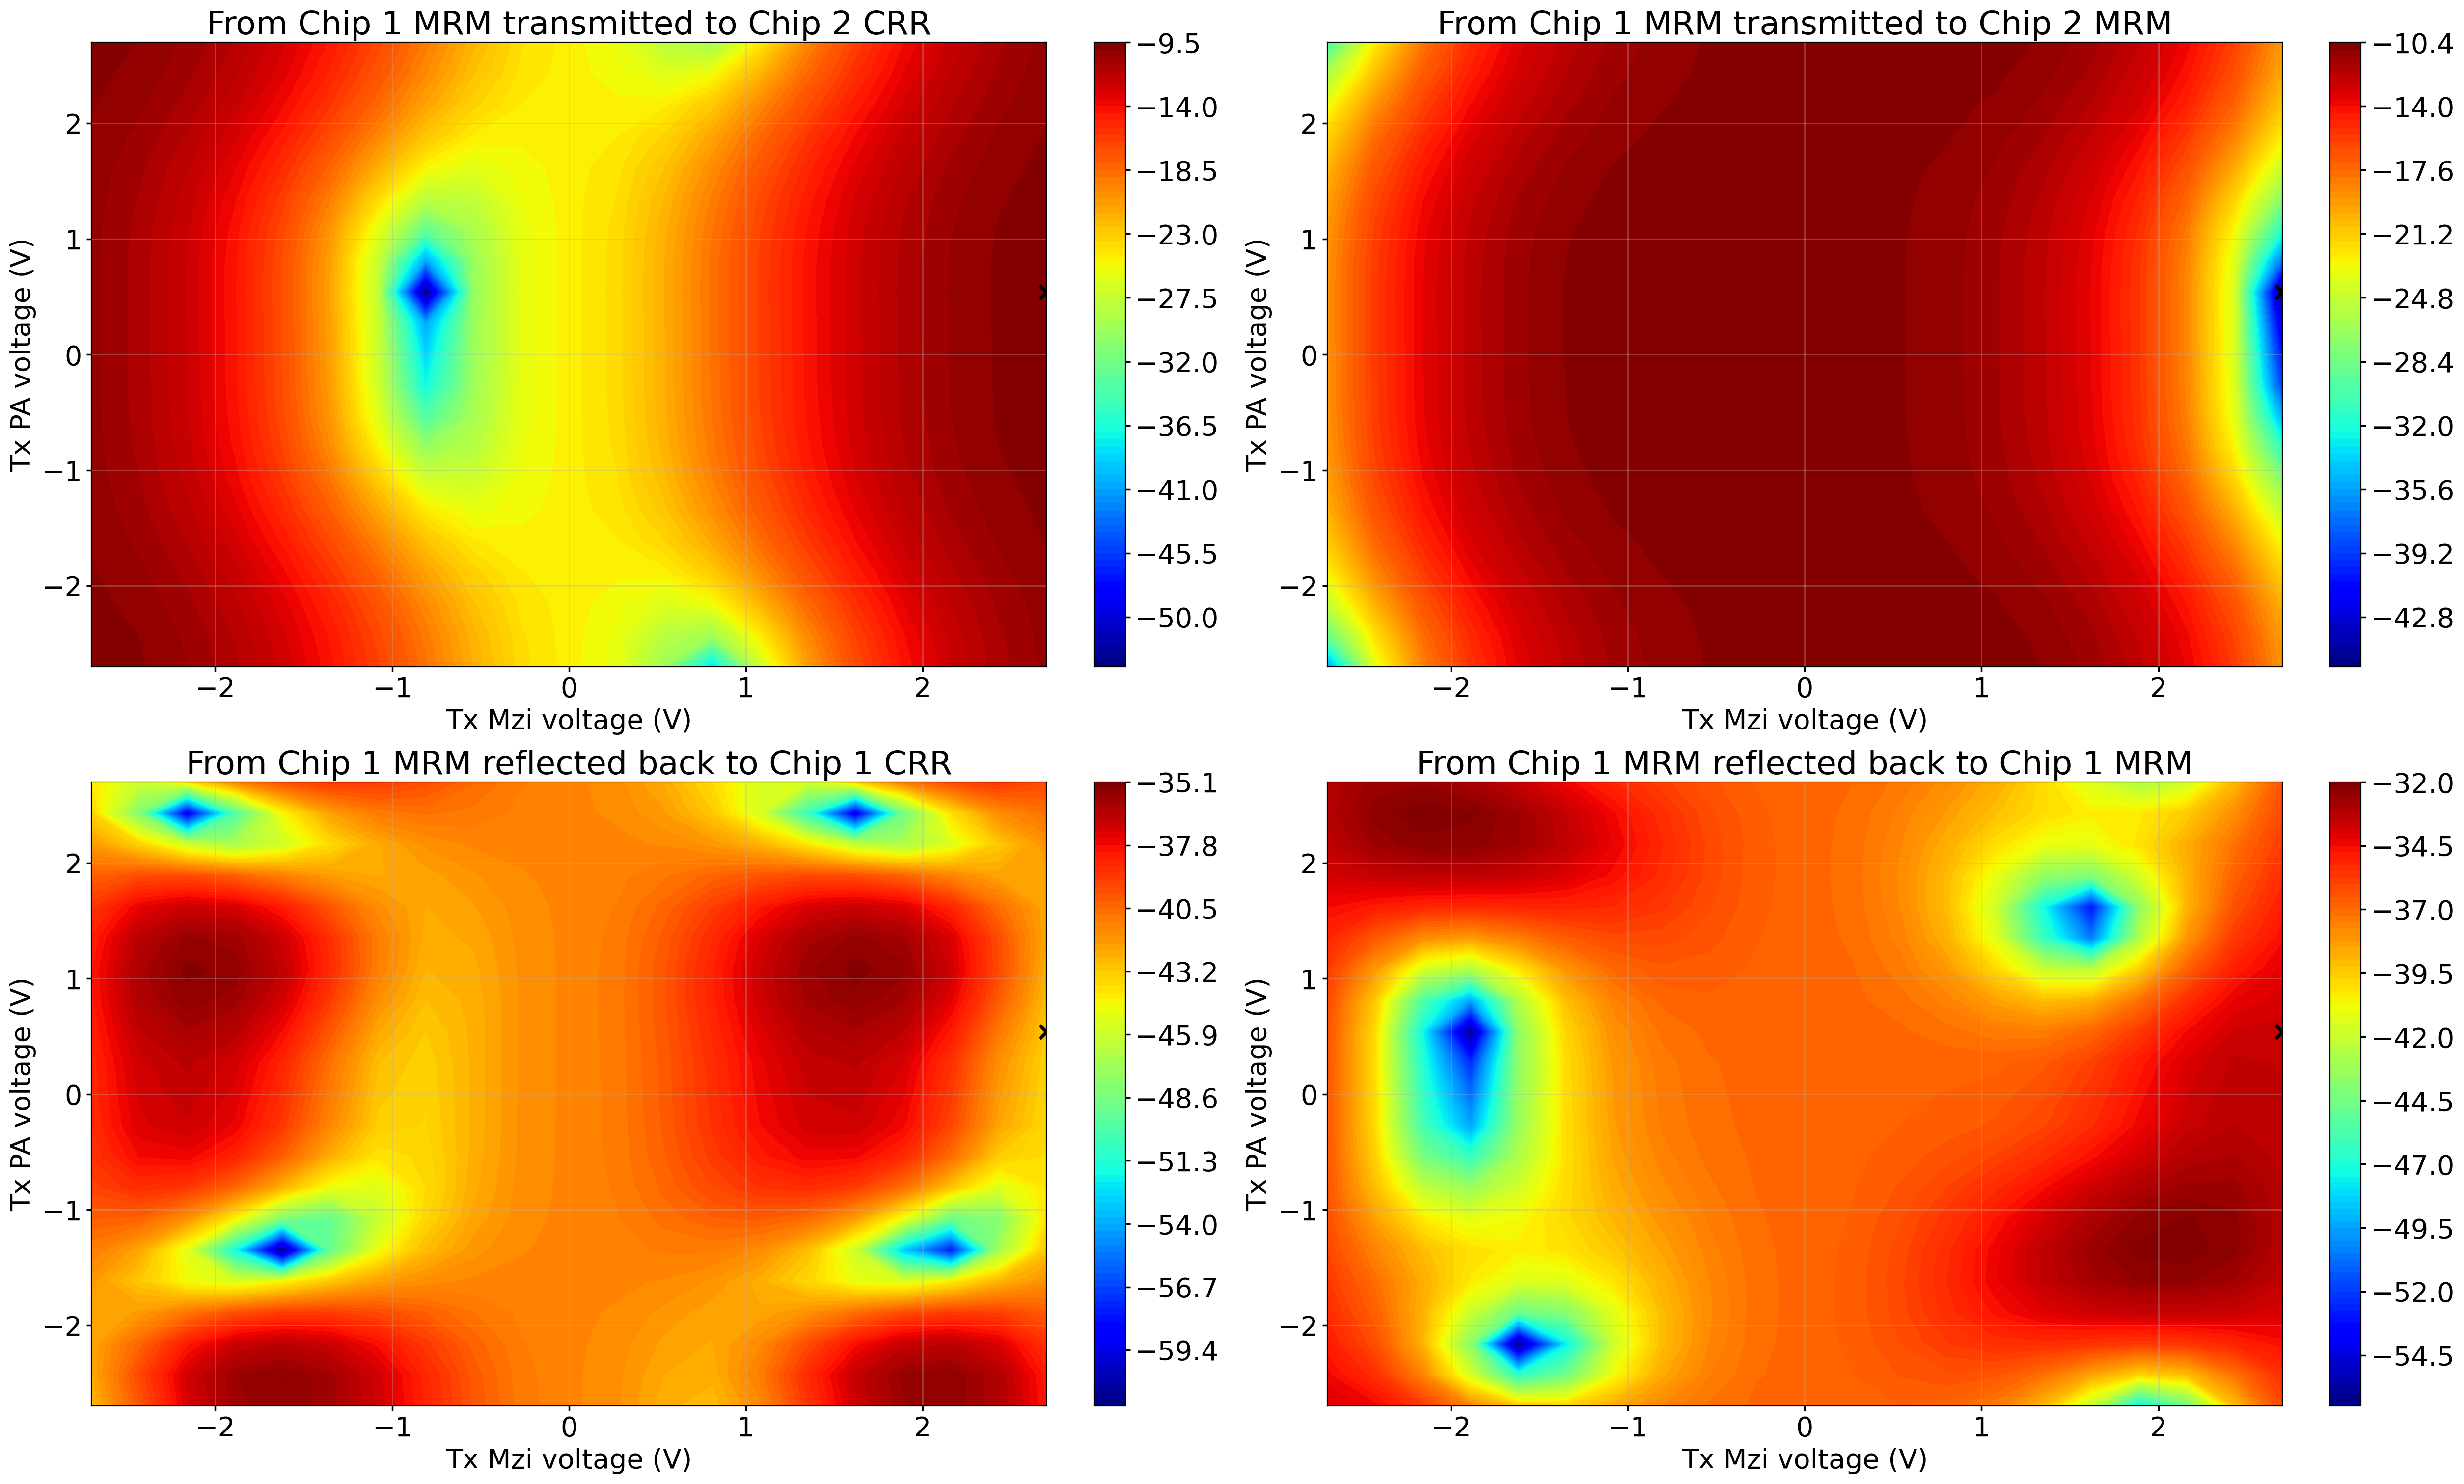

In [11]:
plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(transmit_tm_forward[:,:,idd_rx_pa, idd_rx_mzi]),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[idd_tx_mzi], voltages[idd_tx_pa], marker='x', color='black')
plt.xlabel("Tx Mzi voltage (V)")
plt.ylabel("Tx PA voltage (V)")
plt.title('From Chip 1 MRM transmitted to Chip 2 CRR')
plt.subplot(2, 2, 2)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(transmit_te_forward[:,:,idd_rx_pa, idd_rx_mzi]), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[idd_tx_mzi], voltages[idd_tx_pa], marker='x',color='black')
plt.xlabel("Tx Mzi voltage (V)")
plt.ylabel("Tx PA voltage (V)")
plt.title('From Chip 1 MRM transmitted to Chip 2 MRM')
plt.subplot(2, 2, 3)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(reflect_tm_forward[:,:,idd_rx_pa, idd_rx_mzi]),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[idd_tx_mzi], voltages[idd_tx_pa], marker='x',color='black')
plt.xlabel("Tx Mzi voltage (V)")
plt.ylabel("Tx PA voltage (V)")
plt.title('From Chip 1 MRM reflected back to Chip 1 CRR')
plt.subplot(2, 2, 4)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(reflect_te_forward[:,:,idd_rx_pa, idd_rx_mzi]), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[idd_tx_mzi], voltages[idd_tx_pa],marker='x',color='black')
plt.xlabel("Tx Mzi voltage (V)")
plt.ylabel("Tx PA voltage (V)")
plt.title('From Chip 1 MRM reflected back to Chip 1 MRM')

Text(0.5, 1.0, 'From Chip 1 MRM transmitted to Chip 2 MRM')

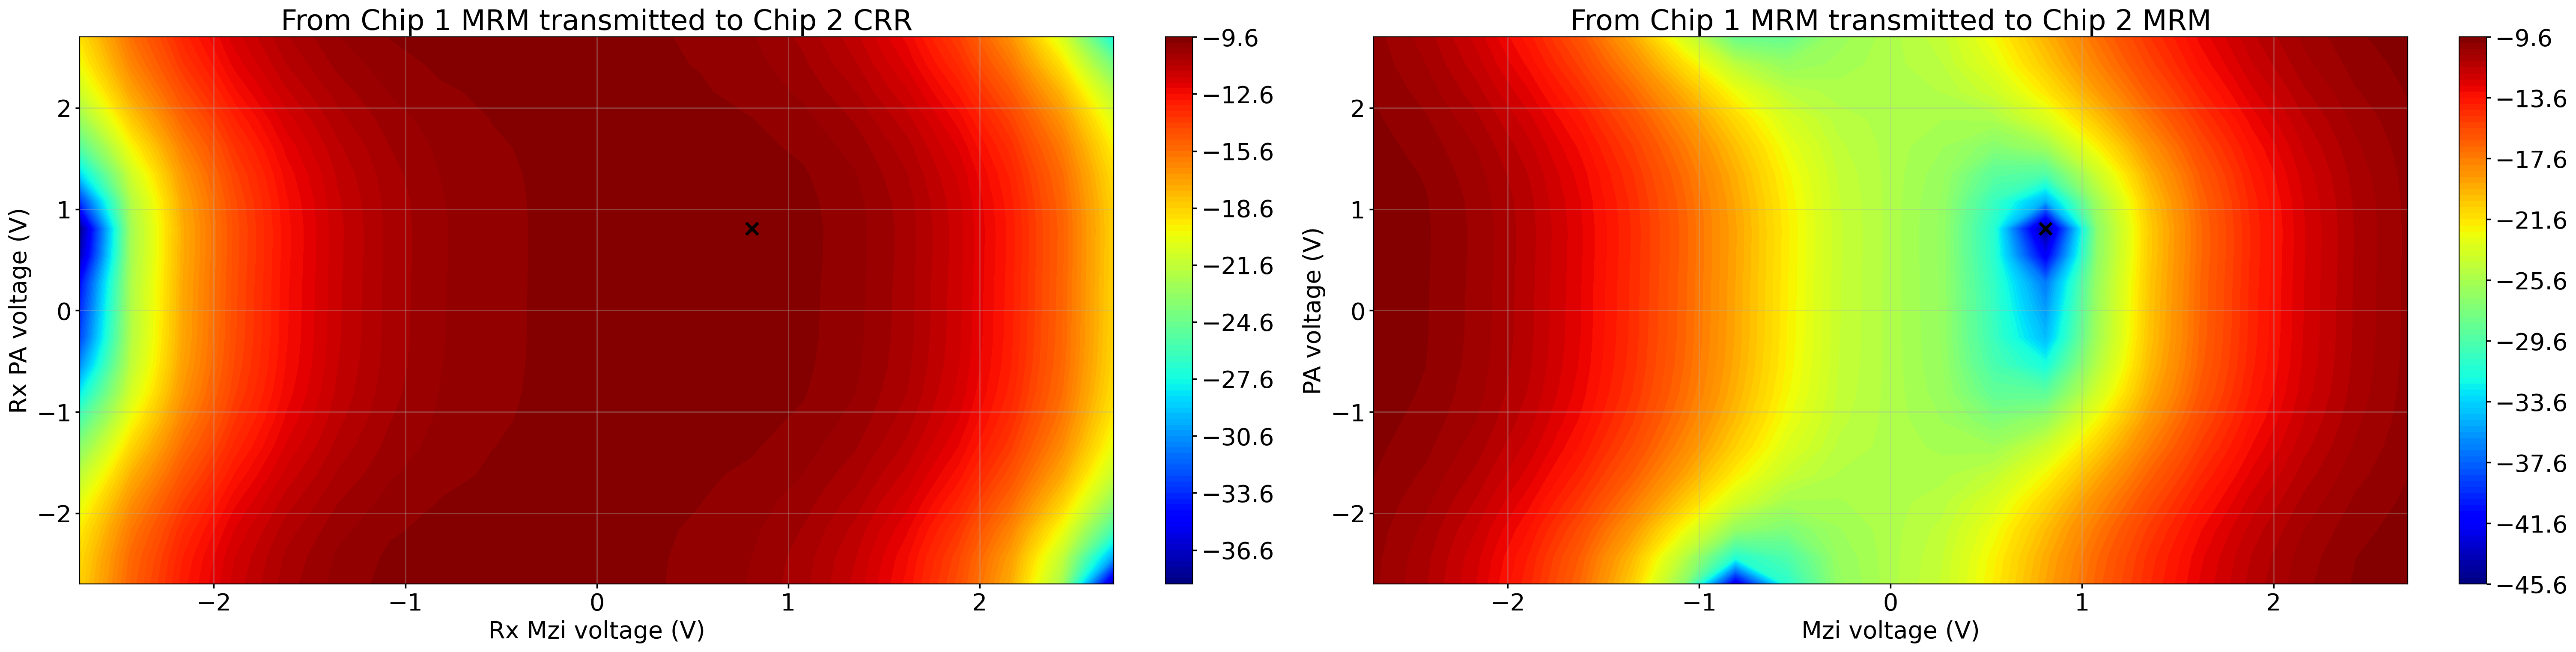

In [12]:
plt.figure(figsize=(30, 7.5))
plt.subplot(1, 2, 1)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(transmit_tm_forward[idd_tx_pa, idd_tx_mzi, :, :]),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[idd_rx_mzi], voltages[idd_rx_pa], marker='x', color='black')
plt.xlabel("Rx Mzi voltage (V)")
plt.ylabel("Rx PA voltage (V)")
plt.title('From Chip 1 MRM transmitted to Chip 2 CRR')
plt.subplot(1, 2, 2)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(transmit_te_forward[idd_tx_pa, idd_tx_mzi, :, :]), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[idd_rx_mzi], voltages[idd_rx_pa], marker='x',color='black')
plt.xlabel("Mzi voltage (V)")
plt.ylabel("PA voltage (V)")
plt.title('From Chip 1 MRM transmitted to Chip 2 MRM')

Text(0.5, 1.0, 'From Chip 1 MRM reflected back to Chip 1 MRM')

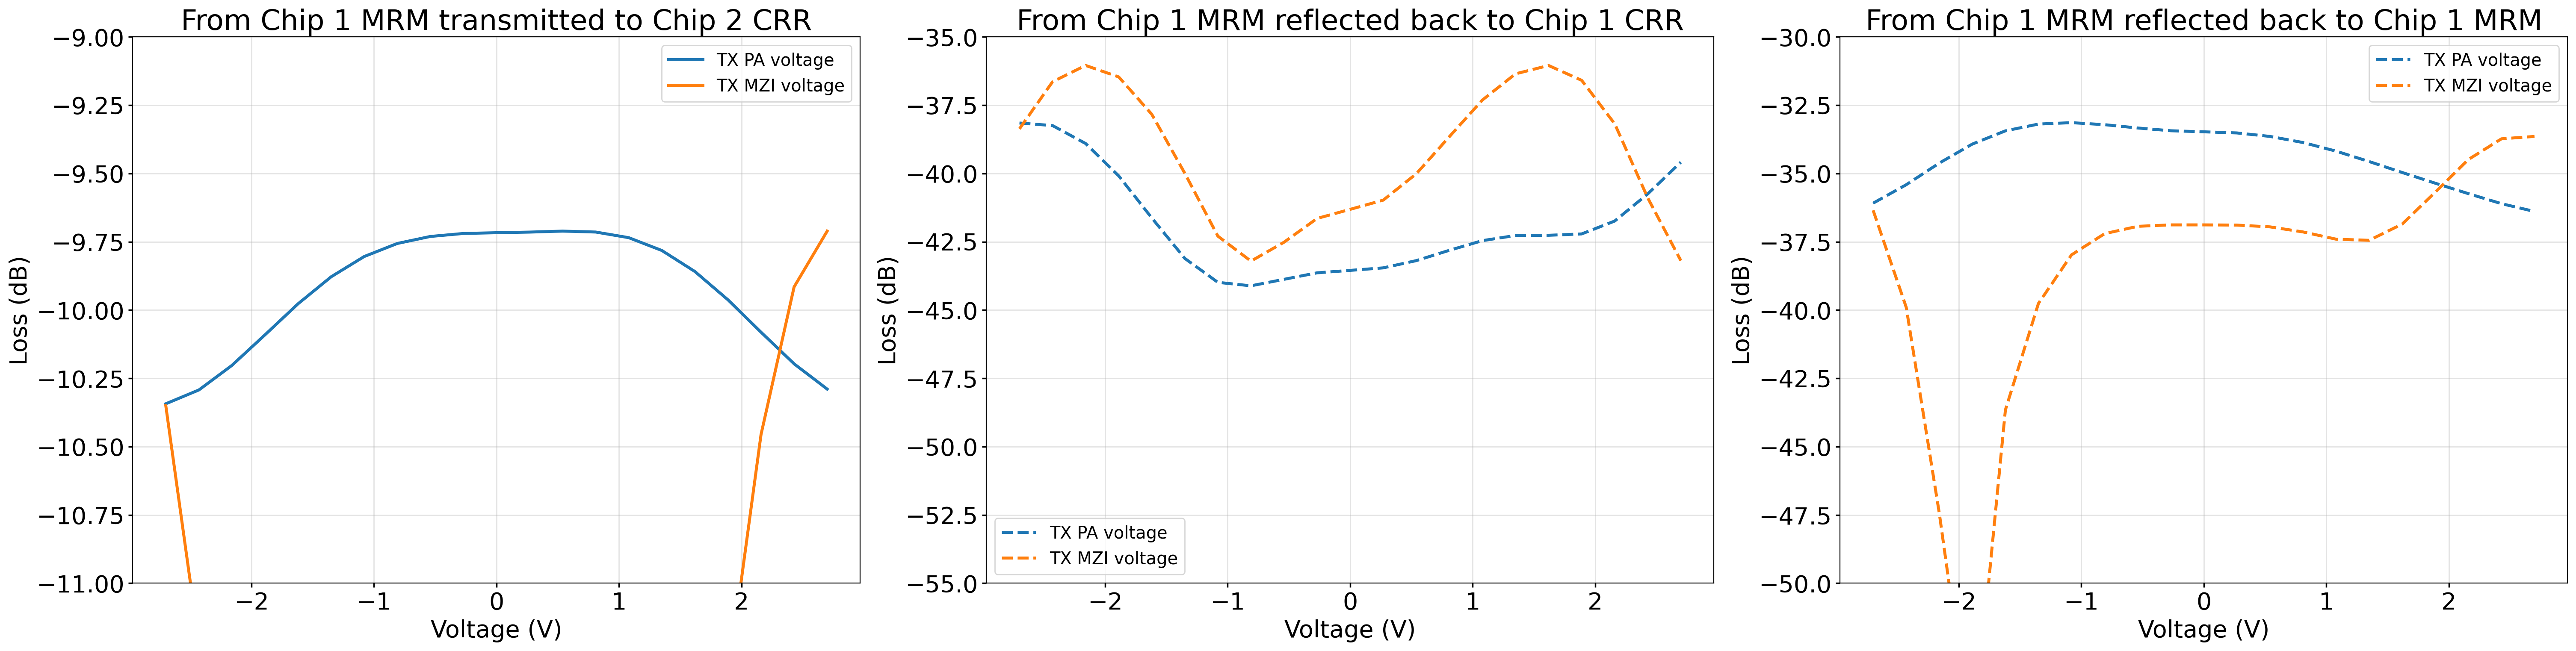

In [13]:
plt.figure(figsize=(30, 7.5))
plt.subplot(131)
plt.plot(voltages, 10*np.log10(transmit_tm_forward)[:,idd_tx_mzi,idd_rx_pa, idd_rx_mzi], label='TX PA voltage')
plt.plot(voltages, 10*np.log10(transmit_tm_forward)[idd_tx_pa,:,idd_rx_pa, idd_rx_mzi], label='TX MZI voltage')
plt.ylim([-11, -9])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Loss (dB)")
plt.title('From Chip 1 MRM transmitted to Chip 2 CRR')

plt.subplot(132)
plt.plot(voltages, 10*np.log10(reflect_tm_forward)[:,idd_tx_mzi,idd_rx_pa, idd_rx_mzi], linestyle='--',label='TX PA voltage')
plt.plot(voltages, 10*np.log10(reflect_tm_forward)[idd_tx_pa,:,idd_rx_pa, idd_rx_mzi], linestyle='--',label='TX MZI voltage')
plt.ylim([-55, -35])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Loss (dB)")
plt.title('From Chip 1 MRM reflected back to Chip 1 CRR')

plt.subplot(133)
plt.plot(voltages, 10*np.log10(reflect_te_forward)[:,idd_tx_mzi, idd_rx_pa, idd_rx_mzi], linestyle='--',label='TX PA voltage')
plt.plot(voltages, 10*np.log10(reflect_te_forward)[idd_tx_pa,:, idd_rx_pa, idd_rx_mzi], linestyle='--',label='TX MZI voltage')
plt.ylim([-50, -30])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Loss (dB)")
plt.title('From Chip 1 MRM reflected back to Chip 1 MRM')

## Reverse direction

Text(0.5, 1.0, 'From Chip 2 MRM transmitted to Chip 1 MRM')

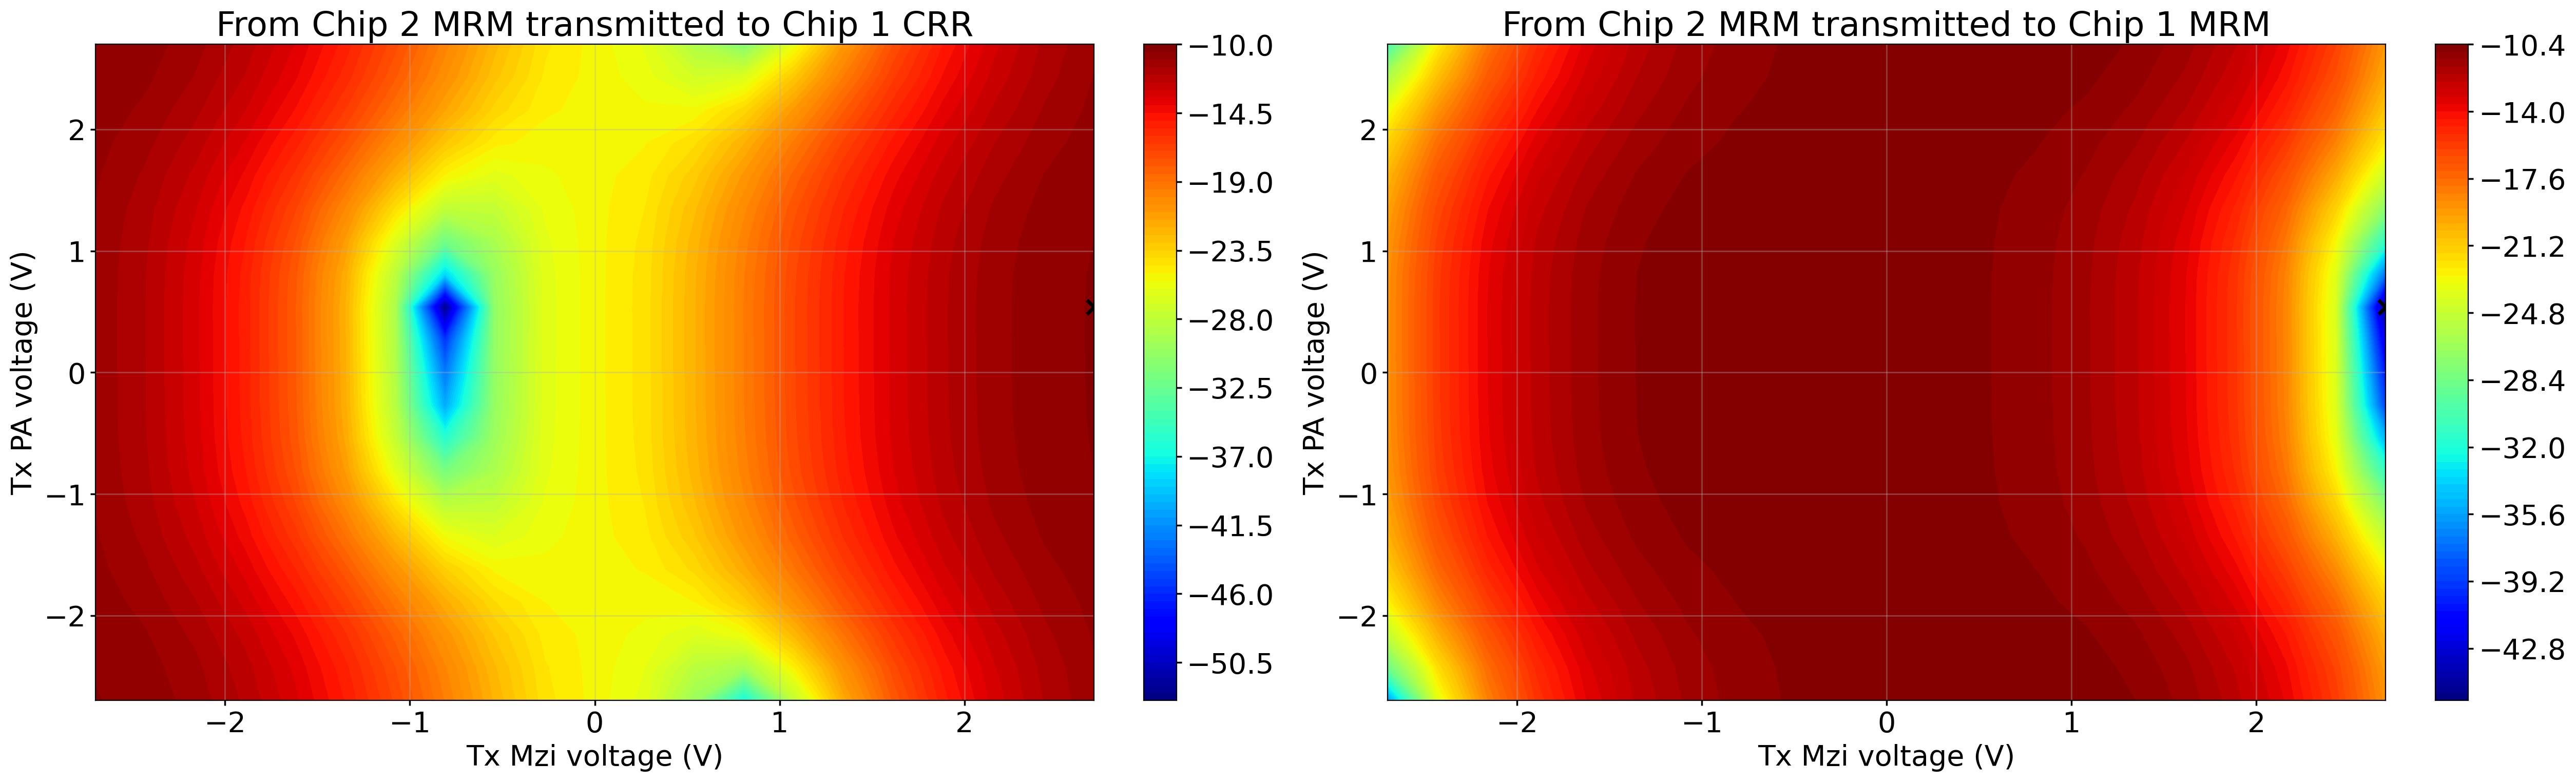

In [14]:
plt.figure(figsize=(25, 7.5))
plt.subplot(1, 2, 1)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(transmit_tm_reverse[:,:,idd_rx_pa, idd_rx_mzi]),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[idd_tx_mzi], voltages[idd_tx_pa], marker='x', color='black')
plt.xlabel("Tx Mzi voltage (V)")
plt.ylabel("Tx PA voltage (V)")
plt.title('From Chip 2 MRM transmitted to Chip 1 CRR')
plt.subplot(1, 2, 2)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(transmit_te_reverse[:,:,idd_rx_pa, idd_rx_mzi]), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[idd_tx_mzi], voltages[idd_tx_pa], marker='x',color='black')
plt.xlabel("Tx Mzi voltage (V)")
plt.ylabel("Tx PA voltage (V)")
plt.title('From Chip 2 MRM transmitted to Chip 1 MRM')

Text(0.5, 1.0, 'From Chip 2 MRM reflected back to Chip 2 MRM')

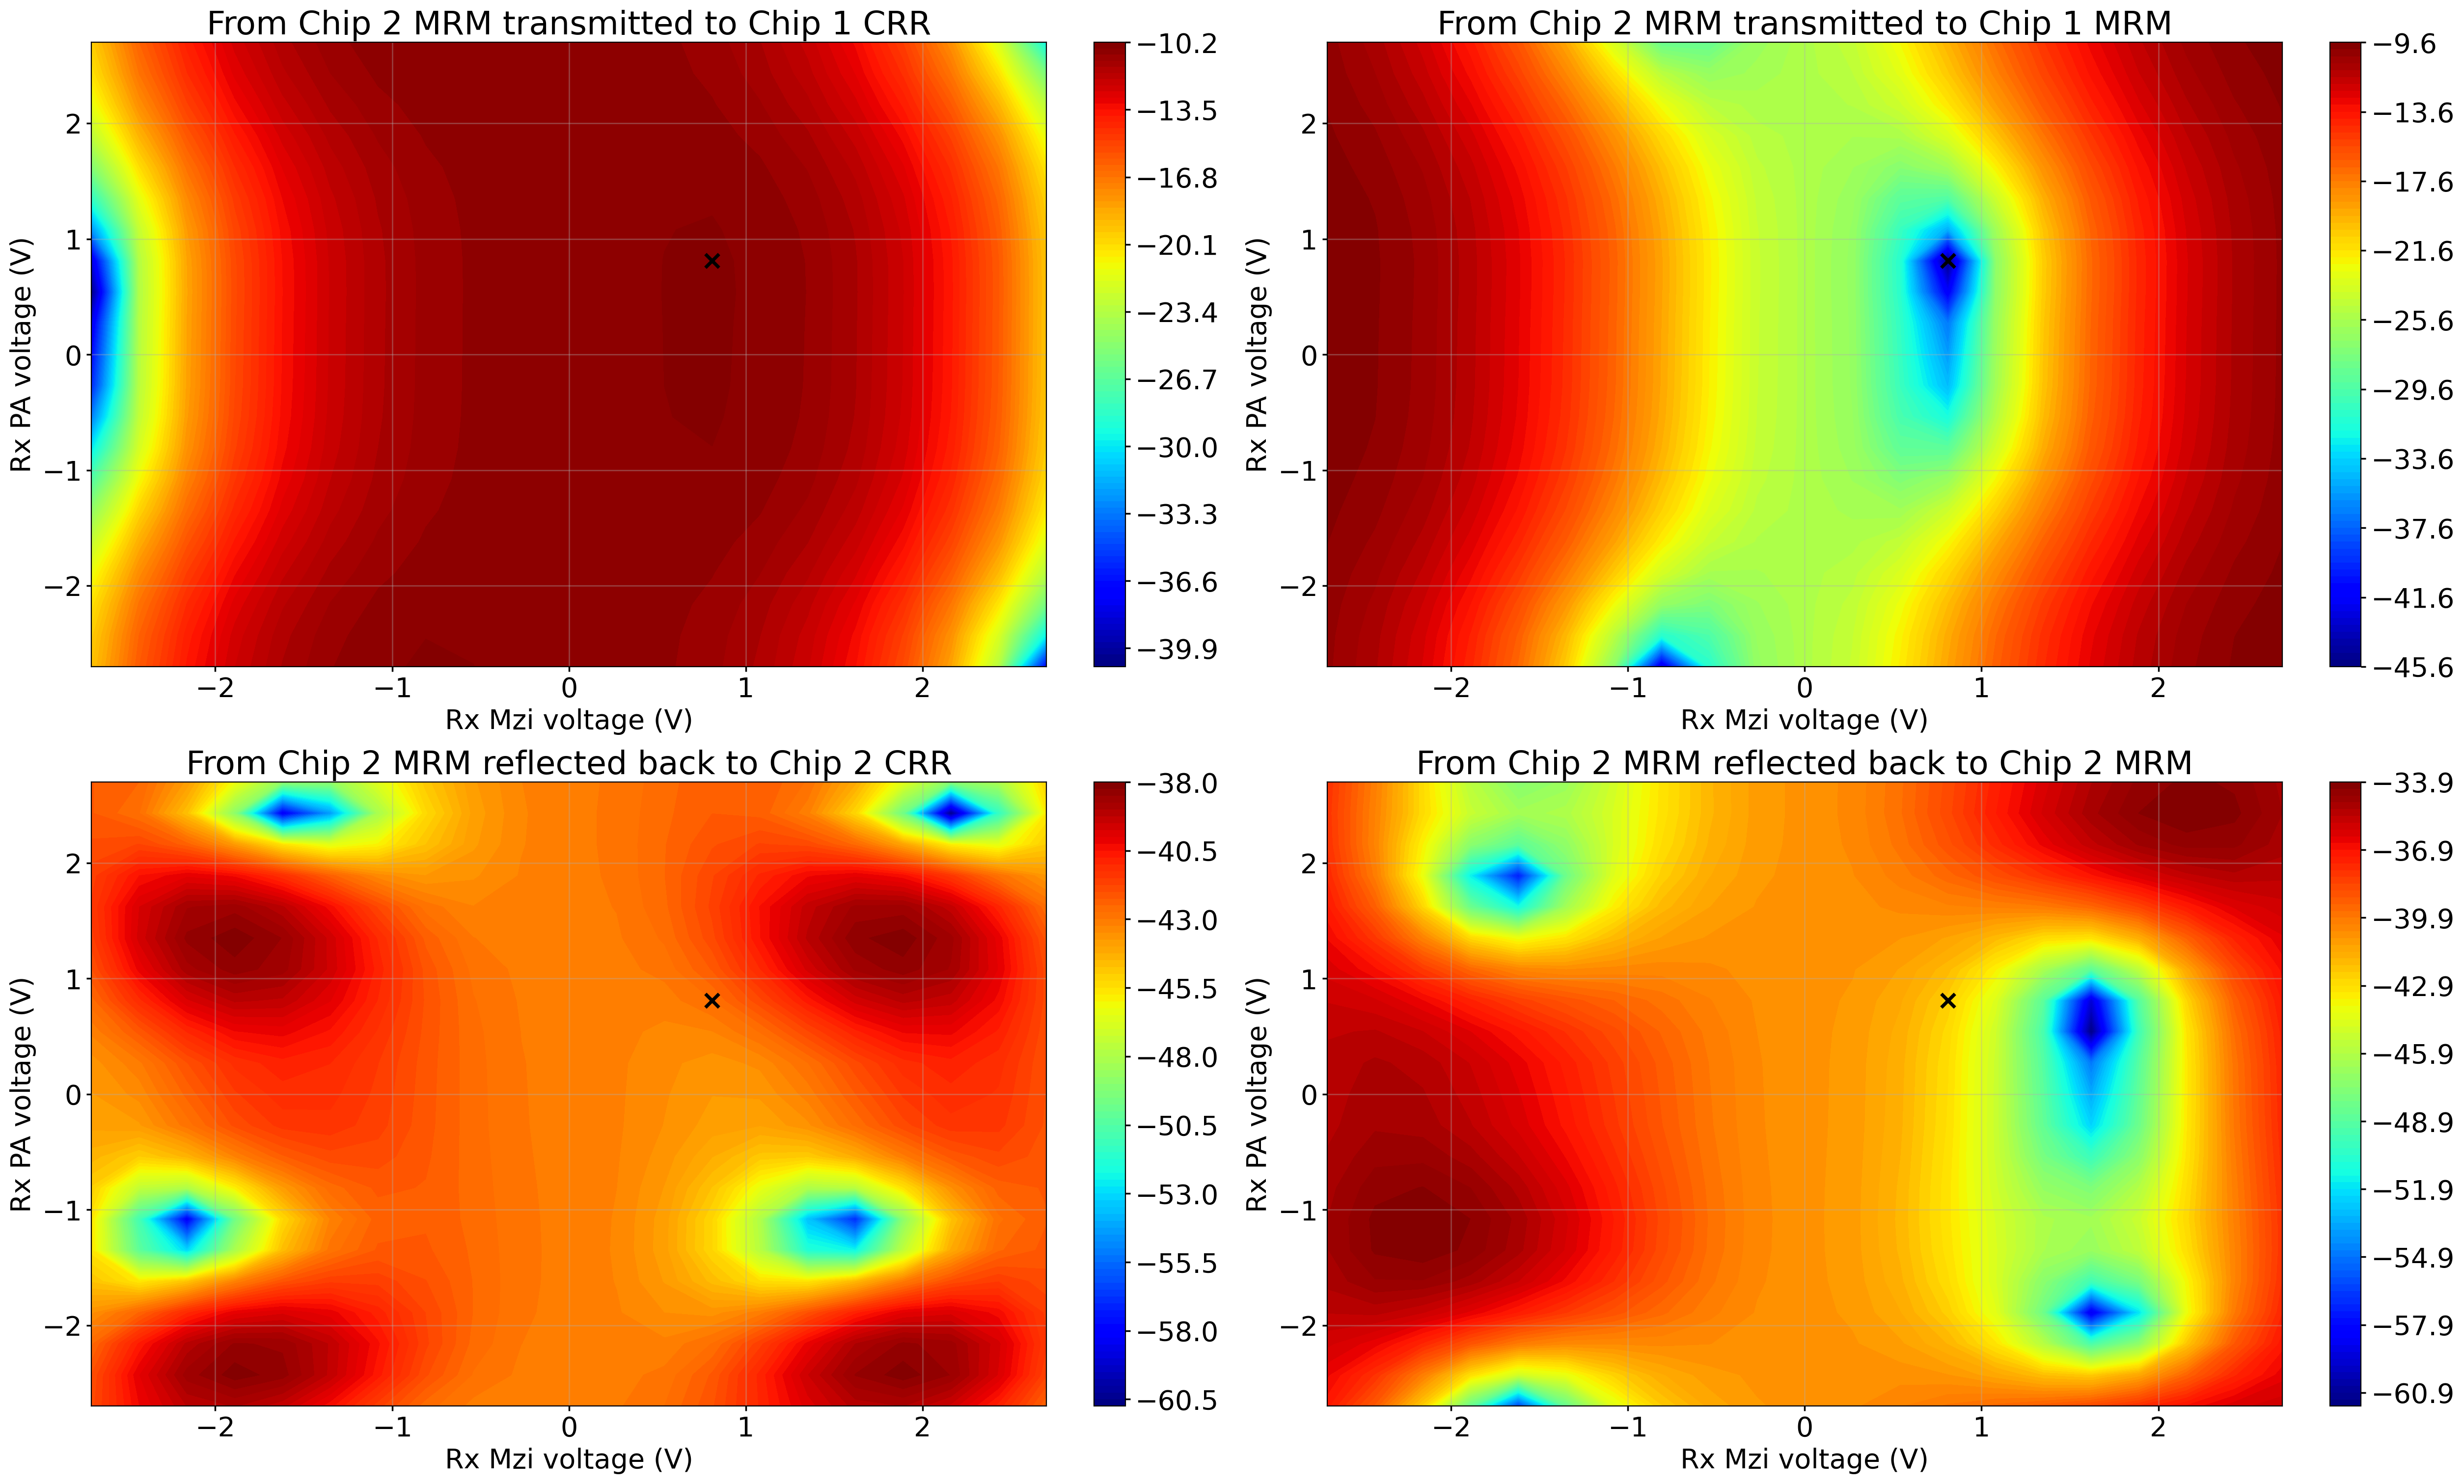

In [15]:
plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(transmit_tm_reverse[idd_tx_pa, idd_tx_mzi, :, :]),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[idd_rx_mzi], voltages[idd_rx_pa], marker='x', color='black')
plt.xlabel("Rx Mzi voltage (V)")
plt.ylabel("Rx PA voltage (V)")
plt.title('From Chip 2 MRM transmitted to Chip 1 CRR')
plt.subplot(2, 2, 2)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(transmit_te_reverse[idd_tx_pa, idd_tx_mzi, :, :]), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[idd_rx_mzi], voltages[idd_rx_pa], marker='x',color='black')
plt.xlabel("Rx Mzi voltage (V)")
plt.ylabel("Rx PA voltage (V)")
plt.title('From Chip 2 MRM transmitted to Chip 1 MRM')
plt.subplot(2, 2, 3)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(reflect_tm_reverse[idd_tx_pa, idd_tx_mzi, :, :]),  levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[idd_rx_mzi], voltages[idd_rx_pa], marker='x',color='black')
plt.xlabel("Rx Mzi voltage (V)")
plt.ylabel("Rx PA voltage (V)")
plt.title('From Chip 2 MRM reflected back to Chip 2 CRR')
plt.subplot(2, 2, 4)
plt.contourf(x_meshgrid, y_meshgrid, 10*np.log10(reflect_te_reverse[idd_tx_pa, idd_tx_mzi, :, :]), levels = 101, cmap='jet')
plt.colorbar()
plt.scatter(voltages[idd_rx_mzi], voltages[idd_rx_pa],marker='x',color='black')
plt.xlabel("Rx Mzi voltage (V)")
plt.ylabel("Rx PA voltage (V)")
plt.title('From Chip 2 MRM reflected back to Chip 2 MRM')

Text(0.5, 1.0, 'From Chip 2 MRM reflected back to Chip 2 MRM')

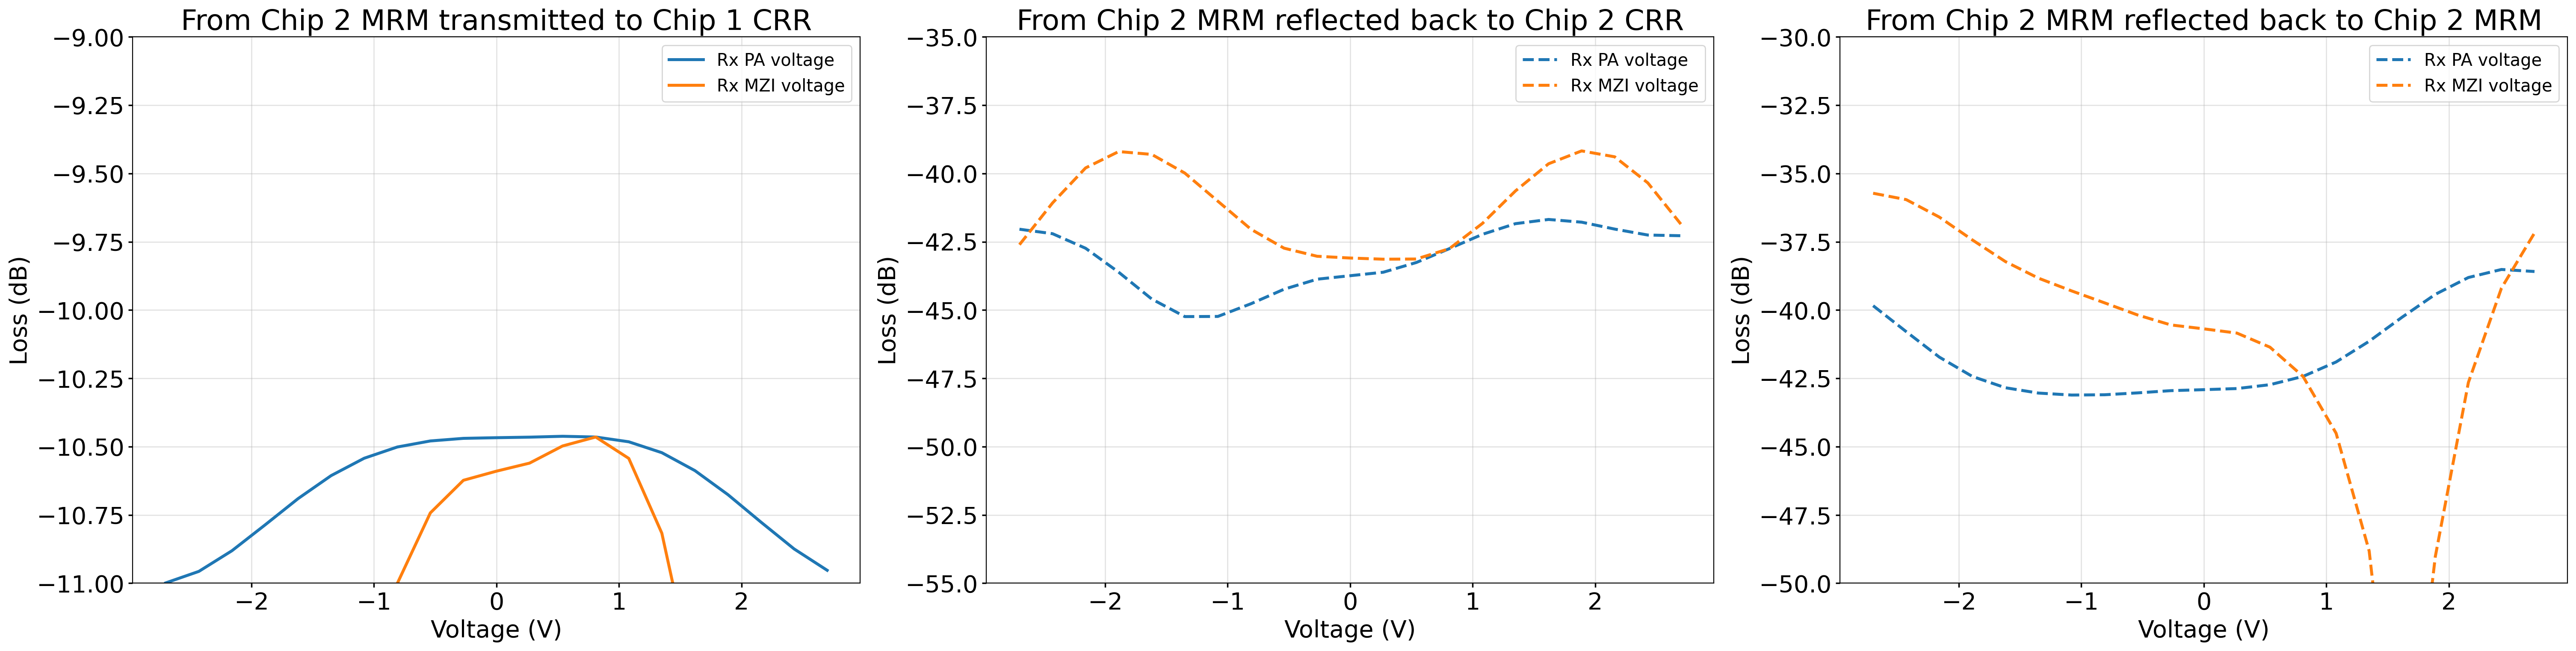

In [16]:
plt.figure(figsize=(30, 7.5))
plt.subplot(131)
plt.plot(voltages, 10*np.log10(transmit_tm_reverse)[idd_tx_pa,idd_tx_mzi,:, idd_rx_mzi], label='Rx PA voltage')
plt.plot(voltages, 10*np.log10(transmit_tm_reverse)[idd_tx_pa,idd_tx_mzi, idd_rx_pa, :], label='Rx MZI voltage')
plt.ylim([-11, -9])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Loss (dB)")
plt.title('From Chip 2 MRM transmitted to Chip 1 CRR')

plt.subplot(132)
plt.plot(voltages, 10*np.log10(reflect_tm_reverse)[idd_tx_pa,idd_tx_mzi,:, idd_rx_mzi], linestyle='--',label='Rx PA voltage')
plt.plot(voltages, 10*np.log10(reflect_tm_reverse)[idd_tx_pa,idd_tx_mzi,idd_rx_pa, :], linestyle='--',label='Rx MZI voltage')
plt.ylim([-55, -35])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Loss (dB)")
plt.title('From Chip 2 MRM reflected back to Chip 2 CRR')

plt.subplot(133)
plt.plot(voltages, 10*np.log10(reflect_te_reverse)[idd_tx_pa,idd_tx_mzi, :, idd_rx_mzi], linestyle='--',label='Rx PA voltage')
plt.plot(voltages, 10*np.log10(reflect_te_reverse)[idd_tx_pa,idd_tx_mzi, idd_rx_pa, :], linestyle='--',label='Rx MZI voltage')
plt.ylim([-50, -30])
plt.legend()
plt.xlabel("Voltage (V)")
plt.ylabel("Loss (dB)")
plt.title('From Chip 2 MRM reflected back to Chip 2 MRM')

## Nelder Meed Search

In [17]:
params = []

In [18]:
def objective_function(voltages):
  """
  Objective function for the optimization.
  Args:
      bidi: Bidi class representing the optical link.
      voltages: Voltages applied to the phase shifters.
      input_state: Input state of the device.
      params: Dictionary of parameters for the optimization.
  Returns:
      The cost function.
  """

  input_state_forward = np.array([1, 0, 0, 0])

  tx_pa_voltage = voltages[0]
  tx_mzi_voltage = voltages[1]
  rx_pa_voltage = voltages[2]
  rx_mzi_voltage = voltages[3]

  p_bidi.bidi_tx.pa.XPS1.heater_voltage = 0.0
  p_bidi.bidi_tx.pa.XPS2.heater_voltage = 0.0
  if tx_pa_voltage > 0.0:
    p_bidi.bidi_tx.pa.XPS1.heater_voltage = tx_pa_voltage
  if tx_pa_voltage < 0.0:
    p_bidi.bidi_tx.pa.XPS2.heater_voltage = -tx_pa_voltage

  p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = 0.0
  p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = 0.0
  if tx_mzi_voltage > 0.0:
    p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = tx_mzi_voltage
  if tx_mzi_voltage < 0.0:
    p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = -tx_mzi_voltage

  p_bidi.bidi_rx.pa.XPS1.heater_voltage = 0.0
  p_bidi.bidi_rx.pa.XPS2.heater_voltage = 0.0
  if rx_pa_voltage > 0.0:
    p_bidi.bidi_rx.pa.XPS1.heater_voltage = rx_pa_voltage
  if rx_pa_voltage < 0.0:
    p_bidi.bidi_rx.pa.XPS2.heater_voltage = -rx_pa_voltage

  p_bidi.bidi_rx.mzi_1.XPS1.heater_voltage = 0.0
  p_bidi.bidi_rx.mzi_1.XPS2.heater_voltage = 0.0
  if rx_mzi_voltage > 0.0:
    p_bidi.bidi_rx.mzi_1.XPS1.heater_voltage = rx_mzi_voltage
  if rx_mzi_voltage < 0.0:
    p_bidi.bidi_rx.mzi_1.XPS2.heater_voltage = -rx_mzi_voltage
    
  p_bidi.recursive_update()

  output_state_forward = p_bidi.smatrix @ input_state_forward

  intensities = np.abs(output_state_forward)**2

  params.append([voltages[0],  voltages[1], voltages[2], voltages[3], intensities[0], intensities[1], intensities[2], intensities[3]])
  
  return -1 * intensities[3]

In [19]:
bounds = [(-2.7, 2.7), (-2.7, 2.7), (-2.7, 2.7), (-2.7, 2.7)]

opts = {
  "maxiter": 1000,
  'xatol': 1e-6,
  'fatol': 1e-6,
}

params = []

result = minimize(
  objective_function,
  ((0.0, 0.0, 0.0, 0.0)),
  bounds=bounds,
  method='Nelder-Mead',
  tol=1e-6,
  )

In [20]:
def plot_optimization(params):
  iters = np.arange(len(params))
  params = np.array(params)
  labels = ['TX-PA','TX-MZI', 'RX-PA', 'RX-MZI']

  plt.figure(figsize=(7.5, 8), dpi=400)
  plt.subplot(2, 1, 1)
  plt.plot(iters, params[:, 0:4], label=labels[0:4])

  plt.ylabel('Voltage [V]')
  plt.xlabel('Iteration number')
  plt.legend(fontsize=12)
  plt.grid(True, which="both", ls="dashed", color='.9')

  labels = [
      "Index-1",
      "Index-2",
      "Index-3",
      "Index-4"
  ]
  plt.subplot(2, 1, 2)
  plt.plot(iters, params[:, 4:], label=labels)

  plt.ylabel('transmission')
  plt.xlabel('Iteration number')
  plt.legend(fontsize=10)
  plt.grid(True, which="both", ls="dashed", color='.9')

In [21]:
params[-1]

[1.082495649872698,
 2.699999999999854,
 1.2285461942313856,
 0.6577736611178227,
 0.0003814457296673888,
 5.681220410793218e-05,
 3.615523608642156e-19,
 0.10701470575393983]

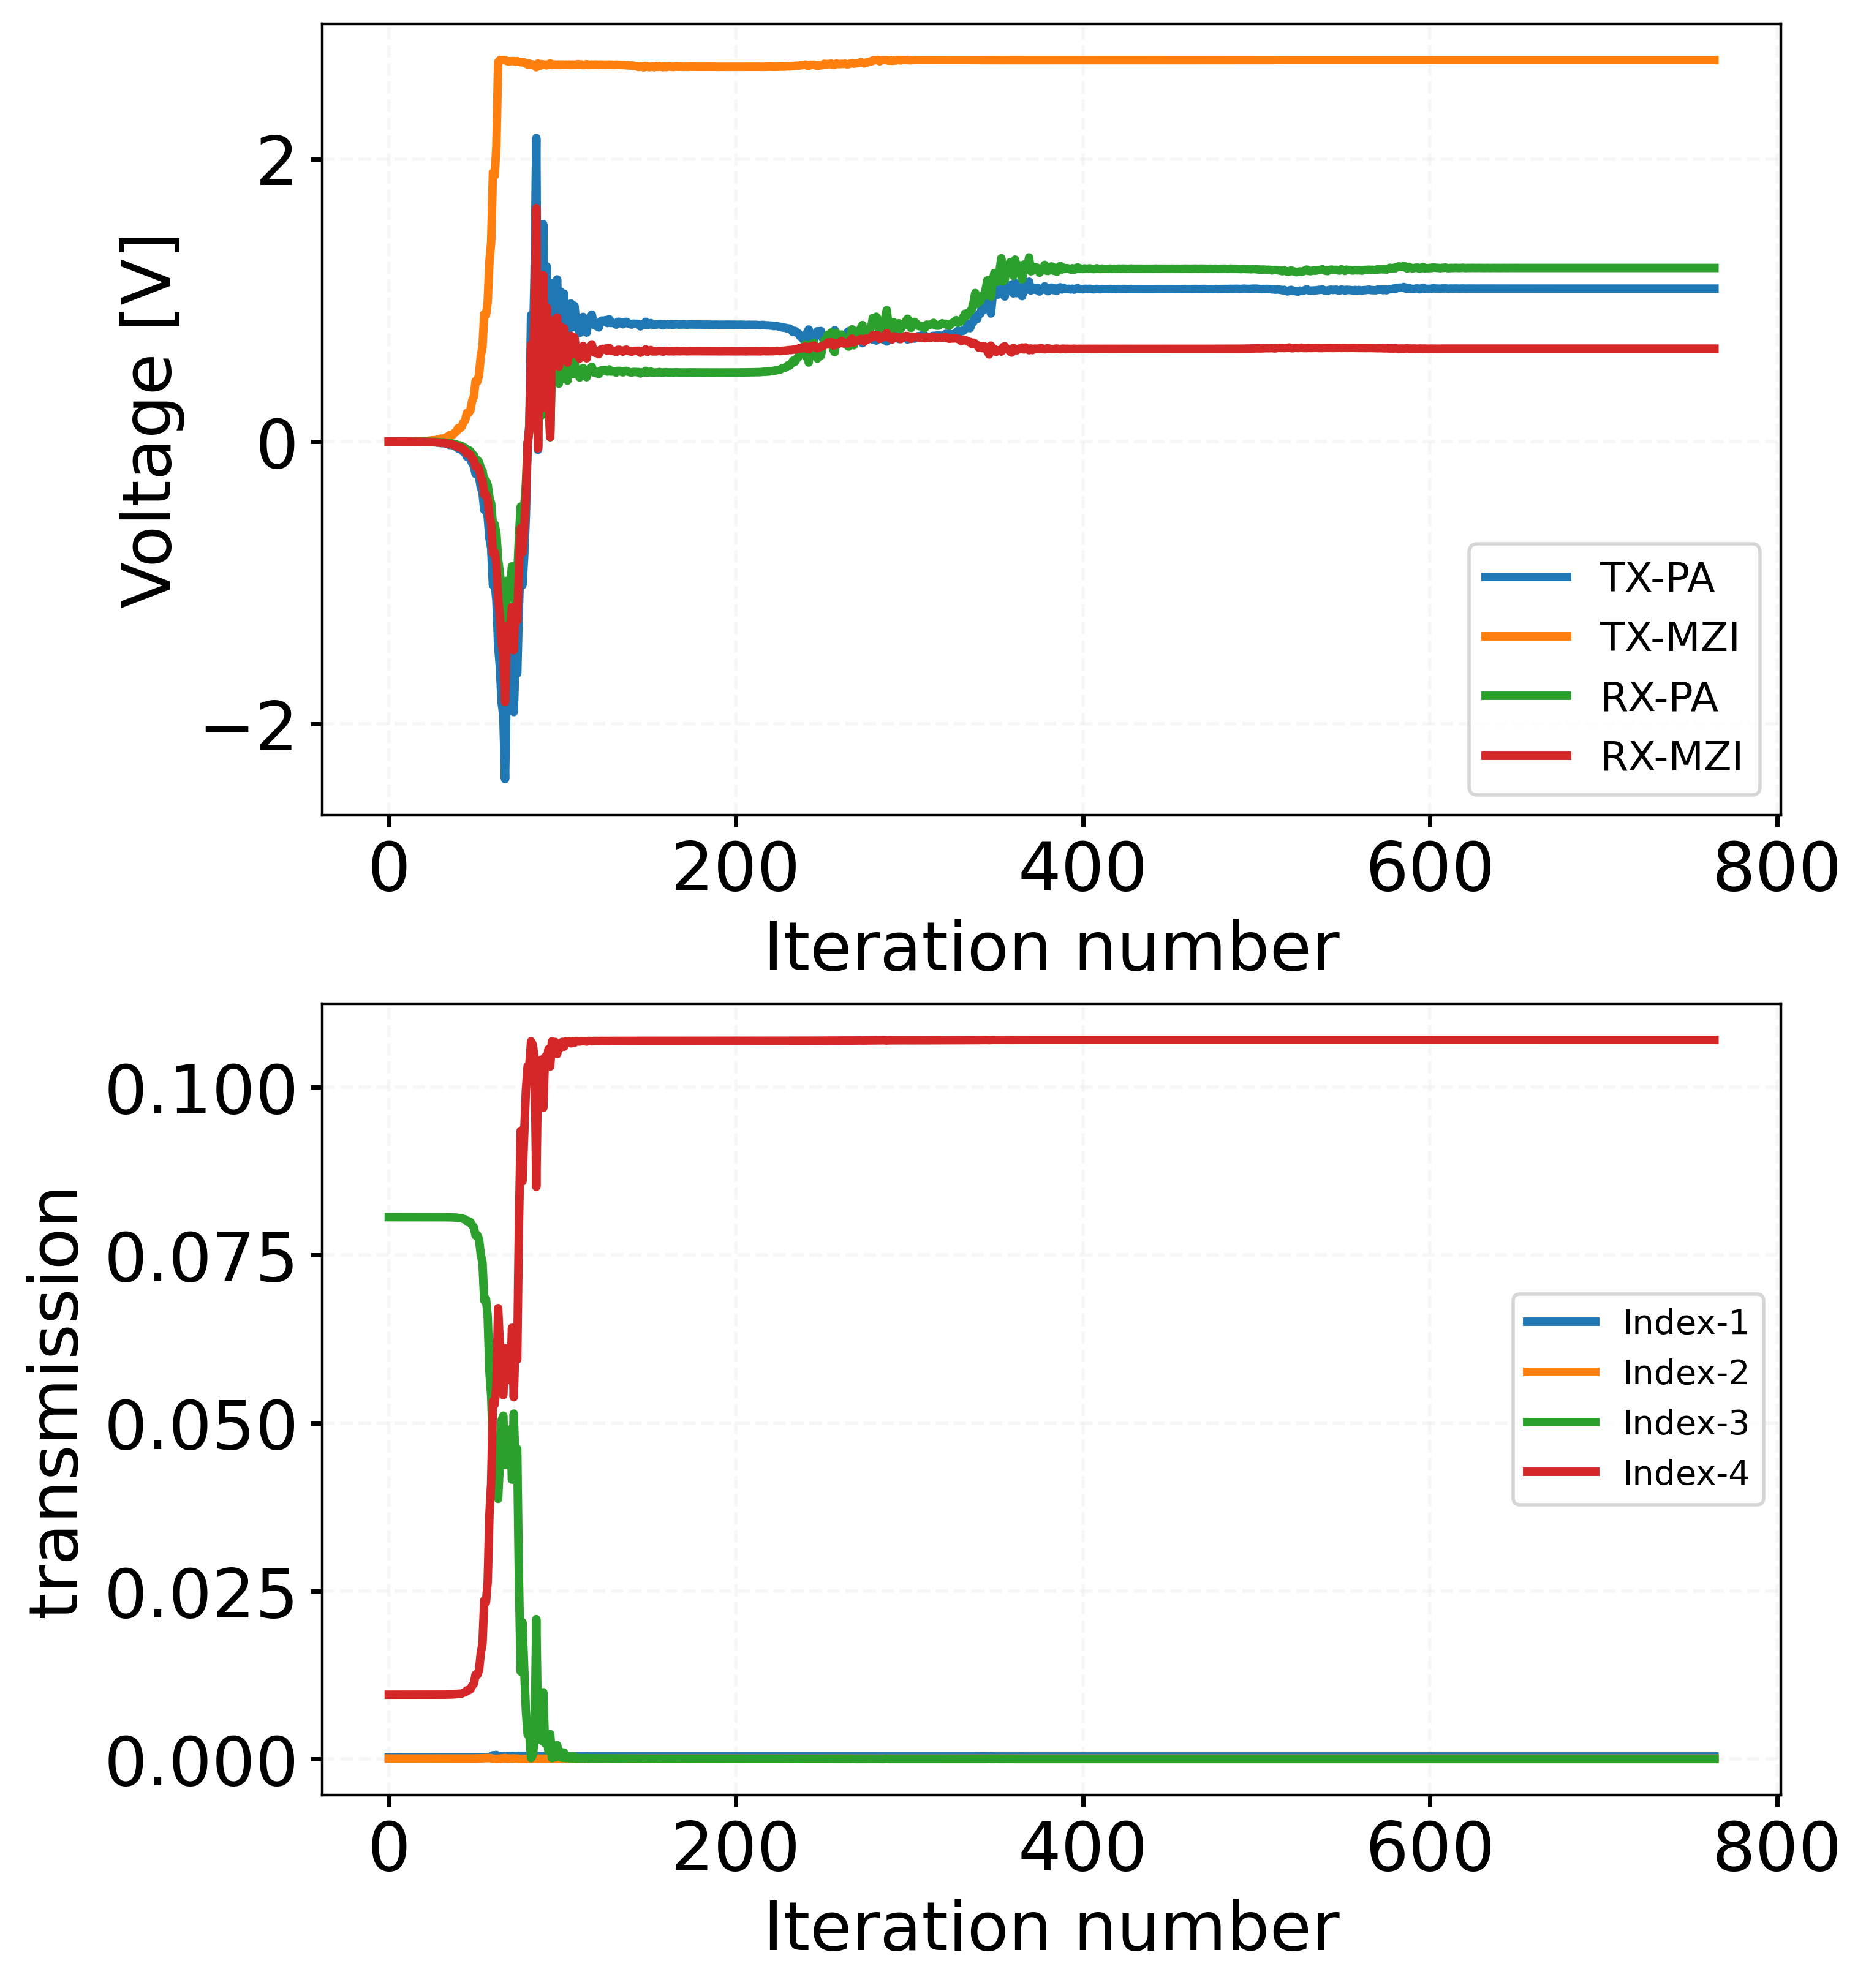

In [22]:
plot_optimization(params)

In [23]:
p_bidi.bidi_tx.pa.XPS1.heater_voltage = 0.0
p_bidi.bidi_tx.pa.XPS2.heater_voltage = 0.0

if params[-1][0] > 0.0:
  p_bidi.bidi_tx.pa.XPS1.heater_voltage = params[-1][0]
if params[-1][0] < 0.0:
  p_bidi.bidi_tx.pa.XPS2.heater_voltage = -params[-1][0]

p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = 0.0
p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = 0.0

if params[-1][1] > 0.0:
  p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = params[-1][1]
if params[-1][1] < 0.0:
  p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = -params[-1][1]

p_bidi.bidi_rx.pa.XPS1.heater_voltage = 0.0
p_bidi.bidi_rx.pa.XPS2.heater_voltage = 0.0

if params[-1][2] > 0.0:
  p_bidi.bidi_rx.pa.XPS1.heater_voltage = params[-1][2]
if params[-1][2] < 0.0:
  p_bidi.bidi_rx.pa.XPS2.heater_voltage = -params[-1][2]

p_bidi.bidi_rx.mzi_1.XPS1.heater_voltage = 0.0
p_bidi.bidi_rx.mzi_1.XPS2.heater_voltage = 0.0

if params[-1][3] > 0.0:
  p_bidi.bidi_rx.mzi_1.XPS1.heater_voltage = params[-1][3]
if params[-1][3] < 0.0:
  p_bidi.bidi_rx.mzi_1.XPS2.heater_voltage = -params[-1][3]

p_bidi.recursive_update()

In [24]:
input_state_forward = np.array([1, 0, 0, 0])
output_state_forward = p_bidi.smatrix @ input_state_forward
print("Output state direction: ", np.abs(output_state_forward)**2)
print("Output state direction in log: ", 10*np.log10(np.abs(output_state_forward)**2))

input_state_reverse = np.array([0, 0, 1, 0])
output_state_reverse = p_bidi.smatrix @ input_state_reverse
print("Output state reverse direction: ", np.abs(output_state_reverse)**2)
print("Output state direction in log: ", 10*np.log10(np.abs(output_state_reverse)**2))

Output state direction:  [3.81445730e-04 5.68122041e-05 3.61552361e-19 1.07014706e-01]
Output state direction in log:  [ -34.18567243  -42.45558361 -184.41828798   -9.70556538]
Output state reverse direction:  [3.61552358e-19 8.98074437e-02 7.69531472e-05 5.59896247e-05]
Output state direction in log:  [-184.41828802  -10.46687665  -41.13773614  -42.51892444]


In [59]:
bias_offset = np.linspace(-0.3, 0.3, num=5)

input_state_forward = np.array([1, 0, 0, 0])
input_state_reverse = np.array([0, 0, 1, 0])
output_state_forward = []
output_state_reverse = []

for tx_pa_bias_offset, tx_mzi_bias_offset, rx_pa_bias_offset, rx_mzi_bias_offset in tqdm(product(bias_offset, bias_offset, bias_offset, bias_offset), total=len(bias_offset)**4):
  p_bidi.bidi_tx.pa.XPS1.heater_voltage = 0.0
  p_bidi.bidi_tx.pa.XPS2.heater_voltage = 0.0
  
  tx_pa_bias = params[-1][0] + tx_pa_bias_offset
  if tx_pa_bias > 0.0:
    p_bidi.bidi_tx.pa.XPS1.heater_voltage = tx_pa_bias
  if tx_pa_bias < 0.0:
    p_bidi.bidi_tx.pa.XPS2.heater_voltage = -tx_pa_bias

  p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = 0.0
  p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = 0.0

  tx_mzi_bias = params[-1][1] + tx_mzi_bias_offset
  if tx_mzi_bias > 0.0:
    p_bidi.bidi_tx.mzi_1.XPS1.heater_voltage = tx_mzi_bias
  if tx_mzi_bias < 0.0:
    p_bidi.bidi_tx.mzi_1.XPS2.heater_voltage = -tx_mzi_bias

  p_bidi.bidi_rx.pa.XPS1.heater_voltage = 0.0
  p_bidi.bidi_rx.pa.XPS2.heater_voltage = 0.0

  rx_pa_bias = params[-1][2] + rx_pa_bias_offset
  if rx_pa_bias > 0.0:
    p_bidi.bidi_rx.pa.XPS1.heater_voltage = rx_pa_bias
  if rx_pa_bias < 0.0:
    p_bidi.bidi_rx.pa.XPS2.heater_voltage = -rx_pa_bias

  p_bidi.bidi_rx.mzi_1.XPS1.heater_voltage = 0.0
  p_bidi.bidi_rx.mzi_1.XPS2.heater_voltage = 0.0

  rx_mzi_bias = params[-1][3] + rx_mzi_bias_offset
  if rx_mzi_bias > 0.0:
    p_bidi.bidi_rx.mzi_1.XPS1.heater_voltage = rx_mzi_bias
  if rx_mzi_bias < 0.0:
    p_bidi.bidi_rx.mzi_1.XPS2.heater_voltage = -rx_mzi_bias

  p_bidi.recursive_update()

  output_state_forward.append(p_bidi.smatrix @ input_state_forward)
  output_state_reverse.append(p_bidi.smatrix @ input_state_reverse)

output_state_forward = np.abs(np.array(output_state_forward).reshape(4, len(bias_offset), len(bias_offset), len(bias_offset), len(bias_offset)))**2
output_state_reverse = np.abs(np.array(output_state_reverse).reshape(4, len(bias_offset), len(bias_offset), len(bias_offset), len(bias_offset)))**2

100%|██████████| 625/625 [00:00<00:00, 1154.27it/s]
